<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#msticpy---ProcessTree" data-toc-modified-id="msticpy---ProcessTree-1">msticpy - ProcessTree</a></span><ul class="toc-item"><li><span><a href="#Extracting-Process-Trees-from-logs" data-toc-modified-id="Extracting-Process-Trees-from-logs-1.1">Extracting Process Trees from logs</a></span></li><li><span><a href="#Process-Tree-utils-module" data-toc-modified-id="Process-Tree-utils-module-1.2">Process Tree utils module</a></span></li><li><span><a href="#Plotting-a-Process-Tree" data-toc-modified-id="Plotting-a-Process-Tree-1.3">Plotting a Process Tree</a></span></li><li><span><a href="#Plotting-Syntax" data-toc-modified-id="Plotting-Syntax-1.4">Plotting Syntax</a></span><ul class="toc-item"><li><span><a href="#Parameter-descriptions" data-toc-modified-id="Parameter-descriptions-1.4.1">Parameter descriptions</a></span><ul class="toc-item"><li><span><a href="#data-:-pd.DataFrame" data-toc-modified-id="data-:-pd.DataFrame-1.4.1.1">data : pd.DataFrame</a></span></li><li><span><a href="#schema-:-ProcSchema,-optional" data-toc-modified-id="schema-:-ProcSchema,-optional-1.4.1.2">schema : ProcSchema, optional</a></span></li><li><span><a href="#output_var-:-str,-optional" data-toc-modified-id="output_var-:-str,-optional-1.4.1.3">output_var : str, optional</a></span></li><li><span><a href="#legend_col-:-str,-optional" data-toc-modified-id="legend_col-:-str,-optional-1.4.1.4">legend_col : str, optional</a></span></li><li><span><a href="#show_table:-bool" data-toc-modified-id="show_table:-bool-1.4.1.5">show_table: bool</a></span></li></ul></li><li><span><a href="#Caveats" data-toc-modified-id="Caveats-1.4.2">Caveats</a></span><ul class="toc-item"><li><span><a href="#Large-data-sets-(more-than-a-few-hundred-processses)" data-toc-modified-id="Large-data-sets-(more-than-a-few-hundred-processses)-1.4.2.1">Large data sets (more than a few hundred processses)</a></span></li><li><span><a href="#Font-Size" data-toc-modified-id="Font-Size-1.4.2.2">Font Size</a></span></li></ul></li></ul></li><li><span><a href="#Linux-Process-Tree" data-toc-modified-id="Linux-Process-Tree-1.5">Linux Process Tree</a></span></li><li><span><a href="#Plotting-Using-a-color-gradient" data-toc-modified-id="Plotting-Using-a-color-gradient-1.6">Plotting Using a color gradient</a></span></li><li><span><a href="#Process-Tree-utility-functions" data-toc-modified-id="Process-Tree-utility-functions-1.7">Process Tree utility functions</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1.7.1">Functions</a></span></li><li><span><a href="#get_summary_info" data-toc-modified-id="get_summary_info-1.7.2">get_summary_info</a></span></li><li><span><a href="#get_roots" data-toc-modified-id="get_roots-1.7.3">get_roots</a></span></li><li><span><a href="#get_descendents" data-toc-modified-id="get_descendents-1.7.4">get_descendents</a></span></li><li><span><a href="#get_children" data-toc-modified-id="get_children-1.7.5">get_children</a></span></li><li><span><a href="#get_tree_depth" data-toc-modified-id="get_tree_depth-1.7.6">get_tree_depth</a></span></li><li><span><a href="#get_parent-and-get_ancestors" data-toc-modified-id="get_parent-and-get_ancestors-1.7.7">get_parent and get_ancestors</a></span></li><li><span><a href="#get_process-and-build_process_key" data-toc-modified-id="get_process-and-build_process_key-1.7.8">get_process and build_process_key</a></span></li><li><span><a href="#get_siblings" data-toc-modified-id="get_siblings-1.7.9">get_siblings</a></span></li></ul></li><li><span><a href="#Display-a-Tree-using-Networkx" data-toc-modified-id="Display-a-Tree-using-Networkx-1.8">Display a Tree using Networkx</a></span></li></ul></li></ul></div>

# msticpy - ProcessTree

This notebook demonstrates the use of the process tree data and visualization modules. These modules can be used with either Windows process creation events (ID 4688) or Linux auditd logs.

You must have msticpy installed to run this notebook:
```
%pip install --upgrade msticpy
```

There are two main components:
- Process Tree creation - this takes a standard log from a single host and builds the parent-child relationships between processes in the data set. There are a set of utility functions to extract individual and partial trees from the processed data set.
- Process Tree visualization - this takes the processed output from the previous component and displays the process tree using Bokeh plots.

Usually, you don't have to do these two steps - the `plot_process_tree` will look at
and try to infer the schema and invoke the process tree builder functions.

You can also do the same thing directly from a data frame containing
process executions:
```ipython
proc_df.mp_plot.process_tree()
```

**Note**  The expected schema for the Linux audit data is as produced by the `auditdextract.py` module in `msticpy`. This module combines related process exec messages into a single combined message that emulates the Windows 4688 event. This retains the audit schema apart from the following additions:
- `cmdline`: this is a concatenation of the `a0`, `a1`, etc argument fields
- `EventType`: this is the audit message type (`SYSCALL`, `EXECVE`, `CWD`, etc.) - the combined `SYSCALL_EXECVE` created by `auditextract` is the only type currently supported.

There is builtin support for other schemas such as Sysmon and Microsoft Defender for endpoint.

## Extracting Process Trees from logs
The input can be either Windows 4688 events or Linux audit events (with the above caveats).

Import libraries and read in test data. Then call `build_process_tree` to extract the parent-child relationships between processes.

In [27]:
from IPython.display import display
import pandas as pd
from msticpy.vis import process_tree

win_procs = pd.read_pickle("./data/win_proc_test.pkl")
display(win_procs.head())

,TenantId,Account,EventID,TimeGenerated,Computer,SubjectUserSid,SubjectUserName,SubjectDomainName,SubjectLogonId,NewProcessId,NewProcessName,TokenElevationType,ProcessId,CommandLine,ParentProcessName,TargetLogonId,SourceComputerId,TimeCreatedUtc
0,52b1ab41-869e-4138-9e40-2a4457f09bf0,WORKGROUP\MSTICAlertsWin1$,4688,2019-02-10 15:21:06.890,MSTICAlertsWin1,S-1-5-18,MSTICAlertsWin1$,WORKGROUP,0x3e7,0xd78,C:\WindowsAzure\GuestAgent_2.7.41491.901_2019-...,%%1936,0x1994,"""CollectGuestLogs.exe"" -Mode:ga -FileName:C:\W...",C:\WindowsAzure\GuestAgent_2.7.41491.901_2019-...,0x0,263a788b-6526-4cdc-8ed9-d79402fe4aa0,2019-02-10 15:21:06.890
1,52b1ab41-869e-4138-9e40-2a4457f09bf0,WORKGROUP\MSTICAlertsWin1$,4688,2019-02-10 15:21:06.907,MSTICAlertsWin1,S-1-5-18,MSTICAlertsWin1$,WORKGROUP,0x3e7,0x221c,C:\Windows\System32\conhost.exe,%%1936,0xd78,\??\C:\Windows\system32\conhost.exe 0xffffffff...,C:\WindowsAzure\GuestAgent_2.7.41491.901_2019-...,0x0,263a788b-6526-4cdc-8ed9-d79402fe4aa0,2019-02-10 15:21:06.907
2,52b1ab41-869e-4138-9e40-2a4457f09bf0,WORKGROUP\MSTICAlertsWin1$,4688,2019-02-10 14:15:36.253,MSTICAlertsWin1,S-1-5-18,MSTICAlertsWin1$,WORKGROUP,0x3e7,0x638,C:\Program Files\Microsoft Monitoring Agent\Ag...,%%1936,0xe24,"""C:\Program Files\Microsoft Monitoring Agent\A...",C:\Program Files\Microsoft Monitoring Agent\Ag...,0x0,263a788b-6526-4cdc-8ed9-d79402fe4aa0,2019-02-10 14:15:36.253
3,52b1ab41-869e-4138-9e40-2a4457f09bf0,WORKGROUP\MSTICAlertsWin1$,4688,2019-02-10 14:15:36.270,MSTICAlertsWin1,S-1-5-18,MSTICAlertsWin1$,WORKGROUP,0x3e7,0x115c,C:\Windows\System32\conhost.exe,%%1936,0x638,\??\C:\Windows\system32\conhost.exe 0xffffffff...,C:\Program Files\Microsoft Monitoring Agent\Ag...,0x0,263a788b-6526-4cdc-8ed9-d79402fe4aa0,2019-02-10 14:15:36.270
4,52b1ab41-869e-4138-9e40-2a4457f09bf0,WORKGROUP\MSTICAlertsWin1$,4688,2019-02-10 15:48:18.437,MSTICAlertsWin1,S-1-5-20,MSTICAlertsWin1$,WORKGROUP,0x3e4,0x2364,C:\Windows\System32\reg.exe,%%1936,0x1c24,"reg ""C:\diagnostics\WinBenignActivity.cmd"" -2...",C:\Windows\System32\cmd.exe,0x0,263a788b-6526-4cdc-8ed9-d79402fe4aa0,2019-02-10 15:48:18.437


In [28]:
p_tree_win = process_tree.build_process_tree(win_procs, show_summary=True)

{'Processes': 1010, 'RootProcesses': 10, 'LeafProcesses': 815, 'BranchProcesses': 185, 'IsolatedProcesses': 0, 'LargestTreeDepth': 7}


## Process Tree utils modules
There are a number of utility functions in other modules
but these are also available/accessible as functions in the main 
`process_tree` module:
```
from msticpy.vis import process_tree
```

These functions include building the parent-child relations as well as a number
of utility functions for manipulating and extracting the trees. 
Most of these latter functions are described in the later section
[Process Tree utility functions](#Process-Tree-utility-functions).


## Plotting a Process Tree

In [29]:
process_tree.plot_process_tree(data=win_procs, legend_col="SubjectUserName", show_table=True, pid_fmt="dec")

Loading BokehJS ...

(Figure(id='1969', ...), Column(id='2104', ...))

## Plotting Syntax

plot_process_tree(
    data,
    schema=None,
    output_var=None,
    legend_colNone,
    show_table=False,
)

### Parameter descriptions

#### data : pd.DataFrame

- DataFrame containing one or more Process Trees. This should be the output of `build_process_tree` described above.

#### schema : ProcSchema, optional

- The data schema to use for the data set, by default None.
  If None the schema is inferred. A schema object maps generic field names (e.g. `process_name`) on to a data-specific name (e.g. `exe` in the case of Linux audit data). This is usually not required since the function will try to infer the schema from fields in the input DataFrame.

#### output_var : str, optional

- Output variable for selected items in the tree, by default None.
  Setting this lets you return the keys of any items selected in the bokeh plot. For example, if you supply the string "my_results" and then select one or more processes in the tree, the Python variable `my_results` will be populated with a list of keys (index items) of the corresponding rows in the input DataFrame.

#### legend_col : str, optional

- The column used to color the tree items, by default None.
  If this column is a string, the values will be treated as categorical data and map unique values to different colors and display a legend of the mapping. If this column is a numeric or datetime value, the values will be treated as continuous and a color gradient bar will be displayed indicating the mapping of values on to the color gradient.

#### show_table: bool

- Set to True to show the data table, by default False.
  Shows the source values as a data table beneath the process tree.

#### height : int, optional

- The height of the plot figure
   (the default is 700)

#### width : int, optional

- The width of the plot figure (the default is 900)

#### title : str, optional

- Title to display (the default is None)

#### hide_legend  : bool, optional

- Hide the legend box, even if legend_col is specified.

#### pid_fmt : str, optional

- Display Process ID as 'dec' (decimal) or 'hex' (hexadecimal),
  default is 'hex'.

---

### Caveats

#### Large data sets (more than a few hundred processses)

These will normally be handled well by the Bokeh plot (up to multiple tens of thousands or more) but it will make navigation of the tree difficult. In particular, the range tool (on the right of the main plot) will be difficult to manipulate. Split the input data into smaller chunks before plotting.

#### Font Size

The font size does not scale based on how much data is shown. If you use the range tool to select too large a subset of the data in the main plot, the font will become unreadable. If this happens, use the `reset` tool to set the plot back to its defaults.


## Linux Process Tree

**Note** This assumes that the Linux audit log has been read from a file using [msticpy.transform.auditdextract.read_from_file()](https://msticpy.readthedocs.io/en/latest/msticpy.transform.html#msticpy.transform.auditdextract.read_from_file) or read from Azure Sentinel/Log Analytics using the LinuxAudit.auditd_all query and processed using [msticpy.sectools.auditdextract.extract_events_to_df()`](https://msticpy.readthedocs.io/en/latest/msticpy.transform.html#msticpy.transform.auditdextract.extract_events_to_df) function.

Using either of these, the process exec events related to a single process start are merged into a single row.


In [30]:
linux_proc = pd.read_pickle("data/linux_proc_test.pkl")
p_tree_lx = process_tree.build_process_tree(linux_proc, show_summary=True, debug=True)

Original # procs 1000
Merged # procs 1000
Merged # procs - dropna 295
Unique merged_procs index in merge 1000
These two should add up to top line
Rows with dups 0
Rows with no dups 1000
0 + 1000 = 1000
original: 1000 inferred_parents 29 combined 1029
{'Processes': 1029, 'RootProcesses': 29, 'LeafProcesses': 497, 'BranchProcesses': 503, 'IsolatedProcesses': 0, 'LargestTreeDepth': 5}


In [31]:
# Take one of those roots and get the full tree beneath it
t_root = process_tree.get_roots(p_tree_lx).iloc[2]
full_tree = process_tree.get_descendents(p_tree_lx, t_root)
print("Full tree size:", len(full_tree))
full_tree.head()

Full tree size: 64


,EventType,TenantId,Computer,mssg_id,TimeGenerated,a0,a1,a2,argc,auid,...,timestamp_orig_par,NewProcessId_par,ParentName,parent_proc_lc,parent_key,IsRoot,IsLeaf,IsBranch,path,parent_index
proc_key,,,,,,,,,,,,,,,,,,,,,
unknown|1350|1970-01-01 00:00:00.000000,SYSCALL_EXECVE,NaN,MSTICAlertsLxVM2,NaN,1970-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,unknown,NaN,NaN,True,False,False,1002,NaN
/usr/bin/sudo|26373|2019-02-17 22:01:26.357000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550440886.357:8972854,2019-02-17 22:01:26.357000+00:00,sudo,/opt/microsoft/omsagent/ruby/bin/ruby,/opt/microsoft/omsagent/plugin/tailfilereader.rb,6.0,-1.0,...,1970-01-01 00:00:00+00:00,1350,unknown,unknown,unknown|1350|1970-01-01 00:00:00.000000,False,False,True,1002/159,1002
/opt/microsoft/omsagent/ruby/bin/ruby|26375|2019-02-17 22:01:26.369000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550440886.369:8972858,2019-02-17 22:01:26.369000+00:00,/opt/microsoft/omsagent/ruby/bin/ruby,/opt/microsoft/omsagent/plugin/tailfilereader.rb,/var/log/audit/audit.log,5.0,-1.0,...,2019-02-17 22:01:26.357000+00:00,NaN,/usr/bin/sudo,/usr/bin/sudo,/usr/bin/sudo|26373|2019-02-17 22:01:26.357000,False,False,True,1002/159/160,159
/usr/bin/sudo|26377|2019-02-17 22:01:26.449000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550440886.449:8972859,2019-02-17 22:01:26.449000+00:00,sudo,test,-f,4.0,-1.0,...,2019-02-17 22:01:26.369000+00:00,NaN,/opt/microsoft/omsagent/ruby/bin/ruby,/opt/microsoft/omsagent/ruby/bin/ruby,/opt/microsoft/omsagent/ruby/bin/ruby|26375|20...,False,False,True,1002/159/160/161,160
/usr/bin/test|26378|2019-02-17 22:01:26.465000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550440886.465:8972863,2019-02-17 22:01:26.465000+00:00,test,-f,/var/log/audit/audit.log,3.0,-1.0,...,2019-02-17 22:01:26.449000+00:00,NaN,/usr/bin/sudo,/usr/bin/sudo,/usr/bin/sudo|26377|2019-02-17 22:01:26.449000,False,True,False,1002/159/160/161/162,161


In [32]:
process_tree.plot_process_tree(data=full_tree[:1000], legend_col="uid")

Loading BokehJS ...

(Figure(id='2330', ...), Row(id='2449', ...))

## Plotting Using a color gradient

In [33]:
proc_rarity = pd.read_pickle("./data/procs_with_cluster.pkl")
proc_rarity_tree = process_tree.build_process_tree(proc_rarity, show_summary=True)

{'Processes': 22992, 'RootProcesses': 31, 'LeafProcesses': 15587, 'BranchProcesses': 7374, 'IsolatedProcesses': 0, 'LargestTreeDepth': 839}


In [34]:
prar_roots = process_tree.get_roots(proc_rarity_tree)

# Find the tree with the highest Rarity Score
tree_rarity = []
for row_num, (ix, row) in enumerate(prar_roots.iterrows()):
    rarity_tree = process_tree.get_descendents(proc_rarity_tree, row)
    tree_rarity.append({
        "Row": row_num,
        "RootProcess": prar_roots.loc[ix].NewProcessName,
        "TreeSize:": len(rarity_tree),
        "AverageRarity": rarity_tree["Rarity"].mean()
    })
    
pd.DataFrame(tree_rarity).sort_values("AverageRarity", ascending=False)

,Row,RootProcess,TreeSize:,AverageRarity
27,27,C:\Windows\System32\svchost.exe,4,0.666726
23,23,C:\Windows\System32\svchost.exe,2,0.500000
22,22,C:\Windows\System32\smss.exe,30,0.398288
20,20,C:\Windows\SoftwareDistribution\Download\Insta...,2,0.333333
9,9,C:\Windows\System32\smss.exe,7,0.250000
7,7,C:\ProgramData\Microsoft\Windows Defender\plat...,46,0.190123
10,10,C:\Windows\System32\winlogon.exe,2,0.166667
5,5,C:\Windows\System32\svchost.exe,21,0.146667
18,18,C:\WindowsAzure\GuestAgent_2.7.41491.901_2019-...,3,0.125089
13,13,C:\Windows\Microsoft.NET\Framework64\v4.0.3031...,2,0.125000


In [35]:
svcs_tree = process_tree.get_descendents(proc_rarity_tree, prar_roots.iloc[22])
# Rarity column gets converted to object type so convert back
svcs_tree.loc[svcs_tree.Rarity.isna(), "Rarity"] = 0
svcs_tree["Rarity"] = pd.to_numeric(svcs_tree.Rarity)
process_tree.plot_process_tree(svcs_tree, legend_col="Rarity", show_table=True)

Loading BokehJS ...

(Figure(id='2562', ...), Column(id='2687', ...))

## Process Tree utility functions

The `process_tree` module has a number of functions that may be useful in extracting or manipulating process trees or tree relationships.

### Functions
- build_process_key
- build_process_tree
- get_ancestors
- get_children
- get_descendents
- get_parent
- get_process
- get_process_key
- get_root
- get_root_tree
- get_roots
- get_siblings
- get_summary_info
- get_tree_depth
- infer_schema

### get_summary_info
Get summary information.

In [36]:
process_tree.get_summary_info(full_tree)

{'Processes': 64,
 'RootProcesses': 1,
 'LeafProcesses': 19,
 'BranchProcesses': 44,
 'IsolatedProcesses': 0,
 'LargestTreeDepth': 5}

### get_roots
Get roots of all trees in the data set.

In [37]:
# Get roots of all trees in the set
process_tree.get_roots(full_tree).head()

,EventType,TenantId,Computer,mssg_id,TimeGenerated,a0,a1,a2,argc,auid,...,timestamp_orig_par,NewProcessId_par,ParentName,parent_proc_lc,parent_key,IsRoot,IsLeaf,IsBranch,path,parent_index
proc_key,,,,,,,,,,,,,,,,,,,,,
unknown|1350|1970-01-01 00:00:00.000000,SYSCALL_EXECVE,NaN,MSTICAlertsLxVM2,NaN,1970-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,unknown,NaN,NaN,True,False,False,1002,NaN


### get_descendents
Get the full tree beneath a process.

In [38]:
full_tree.head()

,EventType,TenantId,Computer,mssg_id,TimeGenerated,a0,a1,a2,argc,auid,...,timestamp_orig_par,NewProcessId_par,ParentName,parent_proc_lc,parent_key,IsRoot,IsLeaf,IsBranch,path,parent_index
proc_key,,,,,,,,,,,,,,,,,,,,,
unknown|1350|1970-01-01 00:00:00.000000,SYSCALL_EXECVE,NaN,MSTICAlertsLxVM2,NaN,1970-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,unknown,NaN,NaN,True,False,False,1002,NaN
/usr/bin/sudo|26373|2019-02-17 22:01:26.357000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550440886.357:8972854,2019-02-17 22:01:26.357000+00:00,sudo,/opt/microsoft/omsagent/ruby/bin/ruby,/opt/microsoft/omsagent/plugin/tailfilereader.rb,6.0,-1.0,...,1970-01-01 00:00:00+00:00,1350,unknown,unknown,unknown|1350|1970-01-01 00:00:00.000000,False,False,True,1002/159,1002
/opt/microsoft/omsagent/ruby/bin/ruby|26375|2019-02-17 22:01:26.369000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550440886.369:8972858,2019-02-17 22:01:26.369000+00:00,/opt/microsoft/omsagent/ruby/bin/ruby,/opt/microsoft/omsagent/plugin/tailfilereader.rb,/var/log/audit/audit.log,5.0,-1.0,...,2019-02-17 22:01:26.357000+00:00,NaN,/usr/bin/sudo,/usr/bin/sudo,/usr/bin/sudo|26373|2019-02-17 22:01:26.357000,False,False,True,1002/159/160,159
/usr/bin/sudo|26377|2019-02-17 22:01:26.449000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550440886.449:8972859,2019-02-17 22:01:26.449000+00:00,sudo,test,-f,4.0,-1.0,...,2019-02-17 22:01:26.369000+00:00,NaN,/opt/microsoft/omsagent/ruby/bin/ruby,/opt/microsoft/omsagent/ruby/bin/ruby,/opt/microsoft/omsagent/ruby/bin/ruby|26375|20...,False,False,True,1002/159/160/161,160
/usr/bin/test|26378|2019-02-17 22:01:26.465000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550440886.465:8972863,2019-02-17 22:01:26.465000+00:00,test,-f,/var/log/audit/audit.log,3.0,-1.0,...,2019-02-17 22:01:26.449000+00:00,NaN,/usr/bin/sudo,/usr/bin/sudo,/usr/bin/sudo|26377|2019-02-17 22:01:26.449000,False,True,False,1002/159/160/161/162,161


In [39]:
# Take one of those roots and get the full tree beneath it
t_root = process_tree.get_roots(full_tree).loc[
    "unknown|1350|1970-01-01 00:00:00.000000"
]
whole_tree = process_tree.get_descendents(full_tree, t_root)
whole_tree.head()

,EventType,TenantId,Computer,mssg_id,TimeGenerated,a0,a1,a2,argc,auid,...,timestamp_orig_par,NewProcessId_par,ParentName,parent_proc_lc,parent_key,IsRoot,IsLeaf,IsBranch,path,parent_index
proc_key,,,,,,,,,,,,,,,,,,,,,
unknown|1350|1970-01-01 00:00:00.000000,SYSCALL_EXECVE,NaN,MSTICAlertsLxVM2,NaN,1970-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,unknown,NaN,NaN,True,False,False,1002,NaN
/usr/bin/sudo|26373|2019-02-17 22:01:26.357000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550440886.357:8972854,2019-02-17 22:01:26.357000+00:00,sudo,/opt/microsoft/omsagent/ruby/bin/ruby,/opt/microsoft/omsagent/plugin/tailfilereader.rb,6.0,-1.0,...,1970-01-01 00:00:00+00:00,1350,unknown,unknown,unknown|1350|1970-01-01 00:00:00.000000,False,False,True,1002/159,1002
/opt/microsoft/omsagent/ruby/bin/ruby|26375|2019-02-17 22:01:26.369000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550440886.369:8972858,2019-02-17 22:01:26.369000+00:00,/opt/microsoft/omsagent/ruby/bin/ruby,/opt/microsoft/omsagent/plugin/tailfilereader.rb,/var/log/audit/audit.log,5.0,-1.0,...,2019-02-17 22:01:26.357000+00:00,NaN,/usr/bin/sudo,/usr/bin/sudo,/usr/bin/sudo|26373|2019-02-17 22:01:26.357000,False,False,True,1002/159/160,159
/usr/bin/sudo|26377|2019-02-17 22:01:26.449000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550440886.449:8972859,2019-02-17 22:01:26.449000+00:00,sudo,test,-f,4.0,-1.0,...,2019-02-17 22:01:26.369000+00:00,NaN,/opt/microsoft/omsagent/ruby/bin/ruby,/opt/microsoft/omsagent/ruby/bin/ruby,/opt/microsoft/omsagent/ruby/bin/ruby|26375|20...,False,False,True,1002/159/160/161,160
/usr/bin/test|26378|2019-02-17 22:01:26.465000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550440886.465:8972863,2019-02-17 22:01:26.465000+00:00,test,-f,/var/log/audit/audit.log,3.0,-1.0,...,2019-02-17 22:01:26.449000+00:00,NaN,/usr/bin/sudo,/usr/bin/sudo,/usr/bin/sudo|26377|2019-02-17 22:01:26.449000,False,True,False,1002/159/160/161/162,161


### get_children
Get the immediate children of a process

In [40]:
# Just get the immediate children of the root process
children = process_tree.get_children(full_tree, t_root)
children.head()

,EventType,TenantId,Computer,mssg_id,TimeGenerated,a0,a1,a2,argc,auid,...,timestamp_orig_par,NewProcessId_par,ParentName,parent_proc_lc,parent_key,IsRoot,IsLeaf,IsBranch,path,parent_index
proc_key,,,,,,,,,,,,,,,,,,,,,
unknown|1350|1970-01-01 00:00:00.000000,SYSCALL_EXECVE,NaN,MSTICAlertsLxVM2,NaN,1970-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,unknown,NaN,NaN,True,False,False,1002,NaN
/usr/bin/sudo|26373|2019-02-17 22:01:26.357000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550440886.357:8972854,2019-02-17 22:01:26.357000+00:00,sudo,/opt/microsoft/omsagent/ruby/bin/ruby,/opt/microsoft/omsagent/plugin/tailfilereader.rb,6.0,-1.0,...,1970-01-01 00:00:00+00:00,1350,unknown,unknown,unknown|1350|1970-01-01 00:00:00.000000,False,False,True,1002/159,1002
/bin/dash|27227|2019-02-17 22:11:17.946000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550441477.946:8973766,2019-02-17 22:11:17.946000+00:00,sh,-c,echo > /dev/null,3.0,-1.0,...,1970-01-01 00:00:00+00:00,1350,unknown,unknown,unknown|1350|1970-01-01 00:00:00.000000,False,True,False,1002/210,1002
/bin/hostname|27232|2019-02-17 22:11:24.494000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550441484.494:8973771,2019-02-17 22:11:24.494000+00:00,hostname,NaN,NaN,1.0,-1.0,...,1970-01-01 00:00:00+00:00,1350,unknown,unknown,unknown|1350|1970-01-01 00:00:00.000000,False,True,False,1002/215,1002
/bin/dash|27233|2019-02-17 22:11:24.498000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550441484.498:8973772,2019-02-17 22:11:24.498000+00:00,sh,-c,hostname -d 2> /dev/null,3.0,-1.0,...,1970-01-01 00:00:00+00:00,1350,unknown,unknown,unknown|1350|1970-01-01 00:00:00.000000,False,False,True,1002/217,1002


### get_tree_depth
Get the depth of a tree.

In [41]:
# Get the depth of the full tree
depth = process_tree.get_tree_depth(full_tree)
print(f"depth of tree is {depth}")

depth of tree is 5


### get_parent and get_ancestors
Get the parent process or all ancestors.

In [42]:
# Get Ancestors
# Get a child process that's at the bottom of the tree
btm_descnt = full_tree[full_tree["path"].str.count("/") == depth - 1].iloc[0]

print("parent")
display(process_tree.get_parent(full_tree, btm_descnt)[:20])
print("ancestors")
process_tree.get_ancestors(full_tree, btm_descnt).head()

parent


EventType                               SYSCALL_EXECVE
TenantId          52b1ab41-869e-4138-9e40-2a4457f09bf0
Computer                              MSTICAlertsLxVM2
mssg_id                         1550440886.449:8972859
TimeGenerated         2019-02-17 22:01:26.449000+00:00
a0                                                sudo
a1                                                test
a2                                                  -f
argc                                               4.0
auid                                              -1.0
cmdline                                  sudo test -f 
cwd                                                  /
egid                                               0.0
euid                                               0.0
exe                                      /usr/bin/sudo
gid                                                0.0
pid                                              26377
ppid                                             26375
proctitle 

ancestors


,EventType,TenantId,Computer,mssg_id,TimeGenerated,a0,a1,a2,argc,auid,...,timestamp_orig_par,NewProcessId_par,ParentName,parent_proc_lc,parent_key,IsRoot,IsLeaf,IsBranch,path,parent_index
proc_key,,,,,,,,,,,,,,,,,,,,,
unknown|1350|1970-01-01 00:00:00.000000,SYSCALL_EXECVE,NaN,MSTICAlertsLxVM2,NaN,1970-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,unknown,NaN,NaN,True,False,False,1002,NaN
/usr/bin/sudo|26373|2019-02-17 22:01:26.357000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550440886.357:8972854,2019-02-17 22:01:26.357000+00:00,sudo,/opt/microsoft/omsagent/ruby/bin/ruby,/opt/microsoft/omsagent/plugin/tailfilereader.rb,6.0,-1.0,...,1970-01-01 00:00:00+00:00,1350,unknown,unknown,unknown|1350|1970-01-01 00:00:00.000000,False,False,True,1002/159,1002
/opt/microsoft/omsagent/ruby/bin/ruby|26375|2019-02-17 22:01:26.369000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550440886.369:8972858,2019-02-17 22:01:26.369000+00:00,/opt/microsoft/omsagent/ruby/bin/ruby,/opt/microsoft/omsagent/plugin/tailfilereader.rb,/var/log/audit/audit.log,5.0,-1.0,...,2019-02-17 22:01:26.357000+00:00,NaN,/usr/bin/sudo,/usr/bin/sudo,/usr/bin/sudo|26373|2019-02-17 22:01:26.357000,False,False,True,1002/159/160,159
/usr/bin/sudo|26377|2019-02-17 22:01:26.449000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550440886.449:8972859,2019-02-17 22:01:26.449000+00:00,sudo,test,-f,4.0,-1.0,...,2019-02-17 22:01:26.369000+00:00,NaN,/opt/microsoft/omsagent/ruby/bin/ruby,/opt/microsoft/omsagent/ruby/bin/ruby,/opt/microsoft/omsagent/ruby/bin/ruby|26375|20...,False,False,True,1002/159/160/161,160
/usr/bin/test|26378|2019-02-17 22:01:26.465000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550440886.465:8972863,2019-02-17 22:01:26.465000+00:00,test,-f,/var/log/audit/audit.log,3.0,-1.0,...,2019-02-17 22:01:26.449000+00:00,NaN,/usr/bin/sudo,/usr/bin/sudo,/usr/bin/sudo|26377|2019-02-17 22:01:26.449000,False,True,False,1002/159/160/161/162,161


### get_process by_process_key
Get a process record by its key.

In [43]:
proc_key = btm_descnt.name
print(proc_key)
process_tree.get_process(full_tree, proc_key)


/usr/bin/test|26378|2019-02-17 22:01:26.465000


EventType                                               SYSCALL_EXECVE
TenantId                          52b1ab41-869e-4138-9e40-2a4457f09bf0
Computer                                              MSTICAlertsLxVM2
mssg_id                                         1550440886.465:8972863
TimeGenerated                         2019-02-17 22:01:26.465000+00:00
a0                                                                test
a1                                                                  -f
a2                                            /var/log/audit/audit.log
argc                                                               3.0
auid                                                              -1.0
cmdline                               test -f /var/log/audit/audit.log
cwd                                                                  /
egid                                                               0.0
euid                                                               0.0
exe   

### get_siblings
Get the siblings of a process.

Some functions take an `include_source` parameter. Setting this to True returns the source process with the result set.

In [44]:
src_proc = process_tree.get_children(full_tree, t_root, include_source=False).iloc[0]
process_tree.get_siblings(full_tree, src_proc, include_source=True).head()


,EventType,TenantId,Computer,mssg_id,TimeGenerated,a0,a1,a2,argc,auid,...,timestamp_orig_par,NewProcessId_par,ParentName,parent_proc_lc,parent_key,IsRoot,IsLeaf,IsBranch,path,parent_index
proc_key,,,,,,,,,,,,,,,,,,,,,
/usr/bin/sudo|26373|2019-02-17 22:01:26.357000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550440886.357:8972854,2019-02-17 22:01:26.357000+00:00,sudo,/opt/microsoft/omsagent/ruby/bin/ruby,/opt/microsoft/omsagent/plugin/tailfilereader.rb,6.0,-1.0,...,1970-01-01 00:00:00+00:00,1350,unknown,unknown,unknown|1350|1970-01-01 00:00:00.000000,False,False,True,1002/159,1002
/bin/dash|27227|2019-02-17 22:11:17.946000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550441477.946:8973766,2019-02-17 22:11:17.946000+00:00,sh,-c,echo > /dev/null,3.0,-1.0,...,1970-01-01 00:00:00+00:00,1350,unknown,unknown,unknown|1350|1970-01-01 00:00:00.000000,False,True,False,1002/210,1002
/bin/hostname|27232|2019-02-17 22:11:24.494000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550441484.494:8973771,2019-02-17 22:11:24.494000+00:00,hostname,NaN,NaN,1.0,-1.0,...,1970-01-01 00:00:00+00:00,1350,unknown,unknown,unknown|1350|1970-01-01 00:00:00.000000,False,True,False,1002/215,1002
/bin/dash|27233|2019-02-17 22:11:24.498000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550441484.498:8973772,2019-02-17 22:11:24.498000+00:00,sh,-c,hostname -d 2> /dev/null,3.0,-1.0,...,1970-01-01 00:00:00+00:00,1350,unknown,unknown,unknown|1350|1970-01-01 00:00:00.000000,False,False,True,1002/217,1002
/bin/dash|27235|2019-02-17 22:11:24.502000,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550441484.502:8973774,2019-02-17 22:11:24.502000+00:00,sh,-c,"/opt/omi/bin/omicli wql root/scx ""SELECT Perce...",3.0,-1.0,...,1970-01-01 00:00:00+00:00,1350,unknown,unknown,unknown|1350|1970-01-01 00:00:00.000000,False,False,True,1002/218,1002


## Display a Tree using Networkx

In [45]:
full_tree.columns

Index(['EventType', 'TenantId', 'Computer', 'mssg_id', 'TimeGenerated', 'a0',
       'a1', 'a2', 'argc', 'auid', 'cmdline', 'cwd', 'egid', 'euid', 'exe',
       'gid', 'pid', 'ppid', 'proctitle', 'ses', 'success', 'uid',
       'EffectiveLogonId', 'new_process_lc', 'source_index', 'pid_par',
       'EffectiveLogonId_par', 'new_process_lc_par', 'source_index_par',
       'ppid_par', 'exe_par', 'timestamp_orig_par', 'NewProcessId_par',
       'ParentName', 'parent_proc_lc', 'parent_key', 'IsRoot', 'IsLeaf',
       'IsBranch', 'path', 'parent_index'],
      dtype='object')

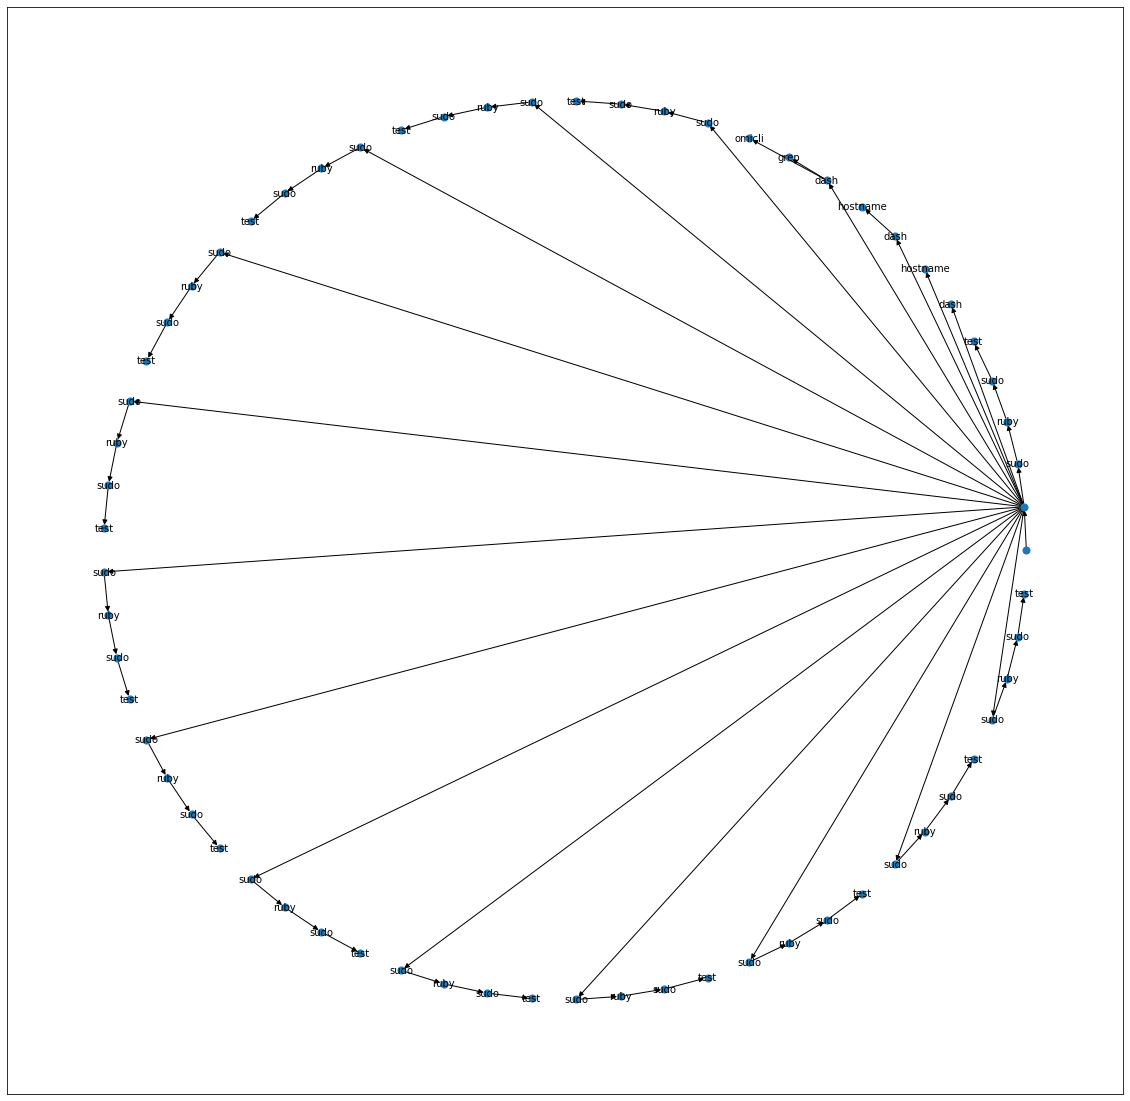

In [46]:
import networkx as nx
import matplotlib.pyplot as plt
p_graph = nx.DiGraph()

p_graph = nx.from_pandas_edgelist(
    df=full_tree.reset_index(),
    source="parent_key",
    target="proc_key",
    edge_attr=["TimeGenerated", "exe", "pid"],
    create_using=nx.DiGraph,
)

plt.gcf().set_size_inches((20,20))
pos = nx.circular_layout(p_graph)
nx.draw_networkx(p_graph, pos=pos, with_labels=False, node_size=50)
# Get the root binary name to plot labels (change the split param for Linux)
labels = full_tree.apply(lambda x: x.exe.split("/")[-1] if isinstance(x.exe, str) else "", axis=1).to_dict()
nx.draw_networkx_labels(p_graph, pos, labels=labels, font_size=10, font_color='k', font_family='sans-serif', font_weight='normal', alpha=1.0)
plt.show()

## Adapting the input schema of your data

The process tree builder uses generic names to map common event
properties such as process name and process ID between different
input schemas.

For example, the schema for Linux auditd data is in the following cell.
The key is the generic name and the value is the input data column
name that will be mapped to the generic field.


In [47]:
import attr
from msticpy.sectools.proc_tree_builder import LX_EVENT_SCH
attr.asdict(LX_EVENT_SCH)

{'process_name': 'exe',
 'process_id': 'pid',
 'parent_id': 'ppid',
 'time_stamp': 'TimeGenerated',
 'cmd_line': 'cmdline',
 'path_separator': '/',
 'user_name': 'acct',
 'logon_id': 'ses',
 'host_name_column': 'Computer',
 'parent_name': None,
 'target_logon_id': None,
 'user_id': 'uid',
 'event_id_column': 'EventType',
 'event_id_identifier': 'SYSCALL_EXECVE'}

If your schema differs from but is similar to one of the built-in
schema mappings you can adapt one of these or supply a custom schema
when you build and display the process tree. The example below
shows how to adapt an existing Linux schema for different column
names in the source schema.

You can also supply a schema as a Python ``dict``, with the keys
being the generic internal name and the values, the names of the columns
in the input data.

```python
from msticpy.nbtools import process_tree as process_tree
from msticpy.sectools.proc_tree_builder import LX_EVENT_SCH
from copy import copy
cust_lx_schema = copy(LX_EVENT_SCH)

cust_lx_schema.time_stamp = "TimeStamp"
cust_lx_schema.host_name_column = "host"
# Note these are used to filter events if you have a data
# set that contains mixed event types.
cust_lx_schema.event_id_column = None
cust_lx_schema.event_id_identifier = None

process_tree.build_process_tree(auditd_df, schema=cust_lx_schema)
```


### Timestamp column

The ``time_stamp`` column must be in pandas Timestamp (Python datetime)
format. If your data is in another format (e.g. Unix timestamp) you should
covert this before trying to use the process tree tools. The example
below shows extracting the timestamp from the auditd mssg_id field.

```python
linux_proc["ts"] = pd.to_numeric(linux_proc["mssg_id"].apply(lambda x: x.split(":")[0]))
linux_proc["time_stamp"] = pd.to_datetime(linux_proc.ts, utc=True)
```
